<font size="4"> <b>Colorful Image Colorization - Run-time Demo Code</b><br></font>
<b>Richard Zhang, Phillip Isola, Alyosha Efros</b><br>
<a href='http://richzhang.github.io/colorization/'>[Project Website]</a> <a href='http://demos.algorithmia.com/colorize-photos/'>[Online Demo]</a> <a href='http://arxiv.org/pdf/1603.08511.pdf'>[Paper]</a><br>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.color as color
import scipy.ndimage.interpolation as sni
import caffe

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

(0) <b> Get the model </b> Download the colorization model. For completeness, we have released a few versions.
 - <b>[Default, classification with class-rebalancing]</b> <i>colorization_release_v2.caffemodel</i> corresponds to our full model from our <a href='http://arxiv.org/pdf/1603.08511.pdf'>ECCV 2016 main paper</a>. This model was cleanly re-trained from scratch, with accompanying training code in this repository.
 - <b>[Classification, no class-rebalancing]</b> <i>colorization_release_v2_norebal.caffemodel</i> is trained with a classification loss with no class re-balancing term. The results are duller but "safer" colorizations.
 - <b>[Old version]</b> <i>colorization_release_v1.caffemodel</i> is an old model, which was used for our original <a href='http://arxiv.org/pdf/1603.08511v1.pdf'>arXiv v1</a> paper, along with the <a href='http://arxiv.org/pdf/1603.08511.pdf'>ECCV 2016 Appendix</a>. The model is trained to take a 224x224 resolution input. (The model was originally versioned as "v0", and retroactively changed to "v1" to match arXiv version numbers)

In [12]:
!wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel -O ../models/colorization_release_v2.caffemodel
# !wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2_norebal.caffemodel -O ../models/colorization_release_v2_norebal.caffemodel
# !wget http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v1/colorization_release_v1.caffemodel -O ../models/colorization_release_v1.caffemodel

--2016-08-10 11:45:07--  http://eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
Resolving eecs.berkeley.edu (eecs.berkeley.edu)... 23.253.180.102
Connecting to eecs.berkeley.edu (eecs.berkeley.edu)|23.253.180.102|:80... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel [following]
--2016-08-10 11:45:07--  https://people.eecs.berkeley.edu/~rich.zhang/projects/2016_colorization/files/demo_v2/colorization_release_v2.caffemodel
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.183
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128946764 (123M)
Saving to: ‘../models/colorization_release_v2.caffemodel’

100%[======================================>] 128,946,764

(1) <b> Opening the model </b> First, we need to open the caffemodel. The model input blob is <i>data_l</i>, and has shape 1x1x256x256 by default. The model output is <i>class8_ab</i>, and has shape 1x2x64x64.

In [13]:
gpu_id = 0
caffe.set_mode_gpu()
caffe.set_device(gpu_id)

# Select desired model
net = caffe.Net('../models/colorization_deploy_v2.prototxt', '../models/colorization_release_v2.caffemodel', caffe.TEST)
# net = caffe.Net('../models/colorization_deploy_v2.prototxt', '../models/colorization_release_v2_norebal.caffemodel', caffe.TEST)
# net = caffe.Net('../models/colorization_deploy_v1.prototxt', '../models/colorization_release_v1.caffemodel', caffe.TEST)
# If you are training your own network, you may replace the *.caffemodel path with your trained network.

(H_in,W_in) = net.blobs['data_l'].data.shape[2:] # get input shape
(H_out,W_out) = net.blobs['class8_ab'].data.shape[2:] # get output shape

print 'Input dimensions: (%i,%i)'%(H_in,W_in)
print 'Output dimensions: (%i,%i)'%(H_out,W_out)

Input dimensions: (224,224)
Output dimensions: (56,56)


<b> (2) Annealed-Mean </b> The <i>annealed mean</i>, described in Section 2.3 of our paper, is implemented as 3 layers in the network: (a) reheat the output distribution (layer <i>conv8_313_rh</i>) (b) convert the softmax to a probability distribution (layer <i> class8_313_rh</i>) (c) take the mean over the annealed distribution (layer <i>class8_ab</i>). Step (c) is implemented as a 1x1 convolution; we need to fill the cluster centers into the parameters of the network.

In [14]:
pts_in_hull = np.load('../resources/pts_in_hull.npy') # load cluster centers
net.params['class8_ab'][0].data[:,:,0,0] = pts_in_hull.transpose((1,0)) # populate cluster centers as 1x1 convolution kernel
print 'Annealed-Mean Parameters populated'

Annealed-Mean Parameters populated


<b> (3) Loading the image </b> Next, we need to load our image of choice. We will convert the image at its full resolution to <i>Lab</i> and keep it's <i>L</i> value; we will concatenate the network's output color to it! We then resize the image to the network input size, convert to <i>Lab</i>, and only keep the resized <i>L</i>, since network of course does not get any color inputs!

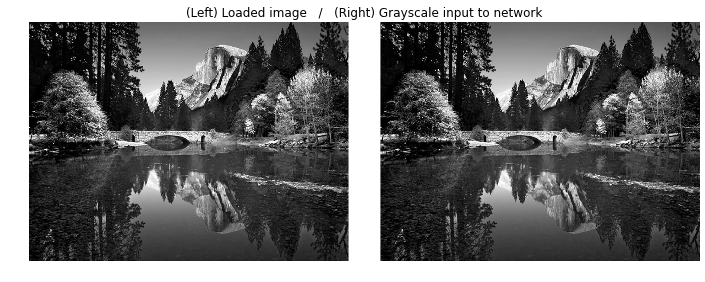

In [15]:
# load the original image
img_rgb = caffe.io.load_image('./imgs/ansel_adams3.jpg')

img_lab = color.rgb2lab(img_rgb) # convert image to lab color space
img_l = img_lab[:,:,0] # pull out L channel
(H_orig,W_orig) = img_rgb.shape[:2] # original image size

# create grayscale version of image (just for displaying)
img_lab_bw = img_lab.copy()
img_lab_bw[:,:,1:] = 0
img_rgb_bw = color.lab2rgb(img_lab_bw)

# resize image to network input size
img_rs = caffe.io.resize_image(img_rgb,(H_in,W_in)) # resize image to network input size
img_lab_rs = color.rgb2lab(img_rs)
img_l_rs = img_lab_rs[:,:,0]

# show original image, along with grayscale input to the network
img_pad = np.ones((H_orig,W_orig/10,3))
plt.imshow(np.hstack((img_rgb, img_pad, img_rgb_bw)))
plt.title('(Left) Loaded image   /   (Right) Grayscale input to network')
plt.axis('off');

<b> (4) Colorization time!</b> Now it is time to run the network. We subtract 50 from the <i>L</i> channel (for mean centering), push it into the network, and run a forward pass. Then, we take the output from <i>class8_ab</i>, resize it to the full resolution, concatenate with the <i>L</i> channel, convert to rgb, and display the result.

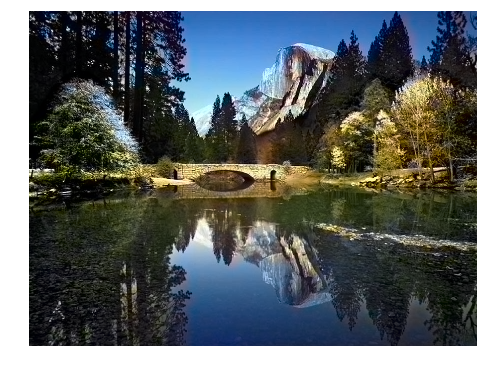

In [16]:
net.blobs['data_l'].data[0,0,:,:] = img_l_rs-50 # subtract 50 for mean-centering
net.forward() # run network

ab_dec = net.blobs['class8_ab'].data[0,:,:,:].transpose((1,2,0)) # this is our result
ab_dec_us = sni.zoom(ab_dec,(1.*H_orig/H_out,1.*W_orig/W_out,1)) # upsample to match size of original image L
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
img_rgb_out = np.clip(color.lab2rgb(img_lab_out),0,1) # convert back to rgb

plt.imshow(img_rgb_out);
plt.axis('off');

<b> (4) Share your results with us</b> Should you wish to share your colorizations with us, please email Richard Zhang with subject <i><b>MyColorization</b></i> at [rich.zhang@eecs.berkeley.edu](rich.zhang@eecs.berkeley.edu).